# 1. Set-up and Cleaning data


## 1.1 Import Libraries

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


In [2]:
# Importing tensorflow and checking its latest version
import tensorflow as tf
print(tf.__version__)


2.3.1


## 1.2 Data Inspection
Check for Corrupt Files: Identifying and removing corrupt images is important because they can cause errors during the model training process or skew the model's learning.
Image Quality Check: Manually inspecting a sample of images helps assess their quality in terms of focus, lighting, and clarity. Poor-quality images can negatively impact the model's ability to learn.

In [4]:
# Check for corrupt files and remove them if any.
import os
from PIL import Image

def check_for_corrupt_files(directory):
    corrupt_files = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  
            except (IOError, SyntaxError) as e:
                corrupt_files.append(filepath)

    return corrupt_files

directory = 'path/to/defungi'  
corrupt_files = check_for_corrupt_files(directory)

if corrupt_files:
    print("Found corrupt or unreadable files:")
    for file in corrupt_files:
        print(file)
else:
    print("No corrupt files found.")

No corrupt files found.


In [5]:
# Check the quality of the images
import numpy as np

def check_image_quality(directory, threshold=0.05):
    """
    Checks for images that are too dark or too bright, indicating potential quality issues.
    :param directory: Directory containing the image dataset.
    :param threshold: Fraction of pixels that are either black or white to consider the image as poor quality.
    """
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img_array = np.array(img)
                    # Check if the image is grayscale or colored
                    if len(img_array.shape) == 2 or img_array.shape[2] == 1:  # Grayscale image
                        n_white = np.sum(img_array >= 255)
                        n_black = np.sum(img_array <= 0)
                    else:  # Colored image
                        n_white = np.sum(np.all(img_array >= [255, 255, 255], axis=2))
                        n_black = np.sum(np.all(img_array <= [0, 0, 0], axis=2))

                    # Check if the image has too many black or white pixels
                    if (n_white + n_black) / img_array.size > threshold:
                        print(f'Image {file} in {subdir} might be of poor quality')
            except IOError:
                # This can catch errors in opening the image file
                print(f'Error opening {file} in {subdir}')

check_image_quality('path/to/defungi')

## 1.3 Data Cleaning
We now check for blurred images and do Aspect Ratio Normalization to resize the images while maintining their originl aspect rtio to prevent distortion. We then enhance the images and print one of the enhanced image as an example. 

In [6]:
! pip install opencv-python-headless Pillow scikit-image

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Libellule\\anaconda3\\envs\\learn-env\\Lib\\site-packages\\~cipy\\sparse\\_sparsetools.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4
  Attempting uninstall: networkx
    Found existing installation: networkx 2.5.1
    Uninstalling networkx-2.5.1:
      Successfully uninstalled networkx-2.5.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.0
    Uninstalling scipy-1.5.0:
      Successfully uninstalled scipy-1.5.0


In [7]:
# Check for blurred images
import cv2
import numpy as np

def is_blurred(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < 100  # threshold for blurriness; adjust as needed


In [8]:
# Resizing the images while maintaining their original aspect ratio
from PIL import Image

def normalize_aspect_ratio(image_path, desired_size=224):
    image = Image.open(image_path)
    old_size = image.size

    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.ANTIALIAS)

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(image, ((desired_size - new_size[0]) // 2,
                        (desired_size - new_size[1]) // 2))

    return new_im

In [9]:
# Enhancing the images
def enhance_image(image_path):
    image = cv2.imread(image_path)
    return cv2.detailEnhance(image, sigma_s=10, sigma_r=0.15)

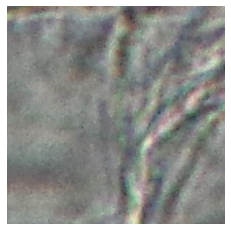

In [10]:
# Printing one of the images
import cv2
from matplotlib import pyplot as plt

# Define the path to the uploaded image, including the file name
image_path = 'defungi/H1/H1_1a_1.jpg'

# Define the image enhancement function
def enhance_image(image_path):
    image = cv2.imread(image_path)
    # Check if the image was correctly loaded
    if image is not None:
        enhanced_image = cv2.detailEnhance(image, sigma_s=10, sigma_r=0.15)
        return enhanced_image
    else:
        raise FileNotFoundError(f"No image found at {image_path}")

# Enhance the image
enhanced = enhance_image(image_path)

# Convert color from BGR to RGB (OpenCV uses BGR by default)
enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(enhanced_rgb)
plt.axis('off')  # Turn off axis numbers
plt.show()

## Data Transformation 
Resizing Images: CNNs require that all images have the same size. Resizing standardizes the input, making it possible to design and train the network.

Normalizing Pixel Values: By scaling the pixel intensities to a range [0, 1], it helps in maintaining numerical stability in the network, as smaller, normalized values make the optimization process more efficient and reliable.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator class.
# We will apply several transformations to augment our dataset which helps to prevent overfitting.

datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the image by normalizing pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2  # Reserve 20% of the data for validation
)

# Create a training data generator.
# This will read images from the directory, apply transformations, and serve them to the model.
train_generator = datagen.flow_from_directory(
    'defungi/',  # This is the path to the training data.
    target_size=(224, 224),  # Resize all images to 224x224 to fit the model expected input
    batch_size=32,  # The size of the batches of data (number of images to be yielded from the generator per batch).
    class_mode='categorical',  # Since we are doing multi-class classification
    subset='training'  # Set as training data
)

# Create a validation data generator.
# It is similar to the training data generator but without the data augmentation part.
# It will only rescale the pixel values.
validation_generator = datagen.flow_from_directory(
    'defungi/',  # Path to the validation data, same as training since the split is made by the generator.
    target_size=(224, 224),  # The images are resized to 224x224 for the same reason as above.
    batch_size=32,  # Same batch size as training
    class_mode='categorical',  # Same class mode as training
    subset='validation'  # Set as validation data
)


Found 7295 images belonging to 5 classes.
Found 1819 images belonging to 5 classes.


# 2 Exploratory Data Analysis (EDA)

## 2.1 Visual Inspection of the Images


Found 9114 images belonging to 5 classes.


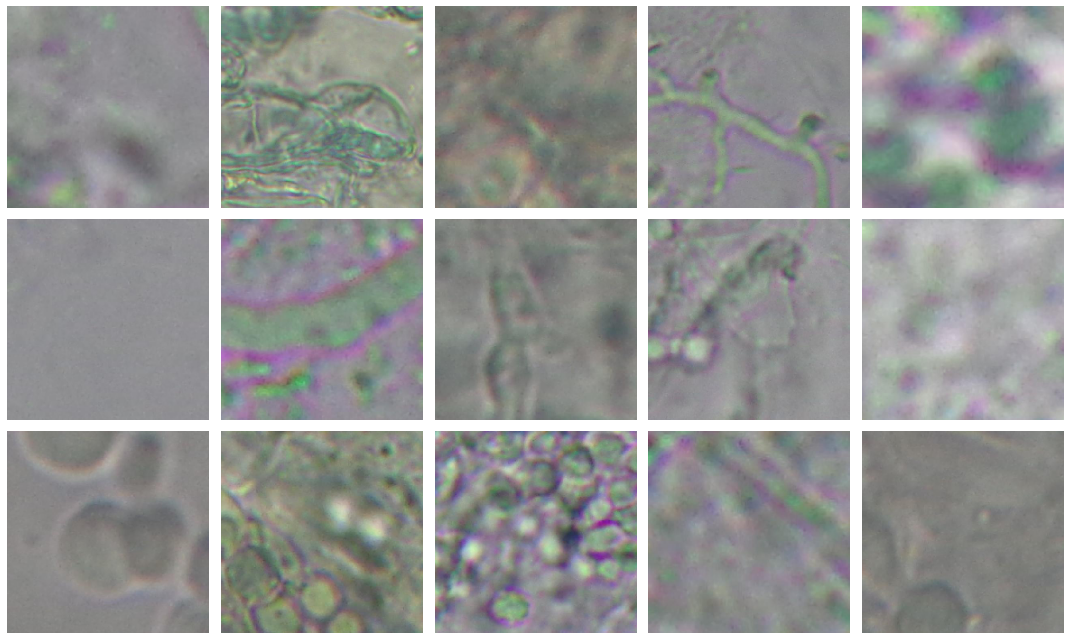

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a new generator without augmentation to view original images
view_datagen = ImageDataGenerator(rescale=1./255)


view_generator = view_datagen.flow_from_directory(
    directory='defungi',
    target_size=(224, 224),
    batch_size=15,  # Display 15 images at a time for visual inspection
    class_mode='categorical',
    shuffle=True)  # Shuffle to get a random set of images

# Get a batch of images
images, labels = next(view_generator)

# Plot the images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Adjust the grid size based on batch size
axes = axes.flatten()
for img, lbl, ax in zip(images, labels, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2.2 Label Distribution Analysis
We will quantify how many images are present in each class and to check for class imbalance. 

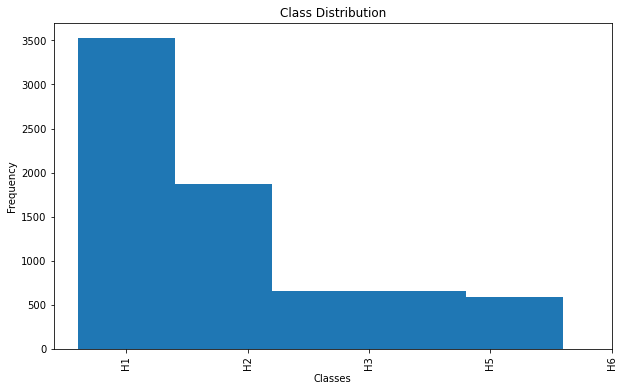

In [14]:
# This code analyzes the distribution of classes (labels) in the dataset.

import matplotlib.pyplot as plt

# Assuming class labels are available in the 'classes' attribute of the generator
class_labels = train_generator.classes
class_indices = train_generator.class_indices

plt.figure(figsize=(10, 6))
plt.hist(class_labels, bins=len(class_indices), align='left')
plt.xticks(ticks=range(len(class_indices)), labels=class_indices.keys(), rotation=90)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

## 2.3 Pixel Intensity Analysis
We analyze the distribution of pixel intensities across the dataset which can give insights into the contrast, brightness, and quality of images.

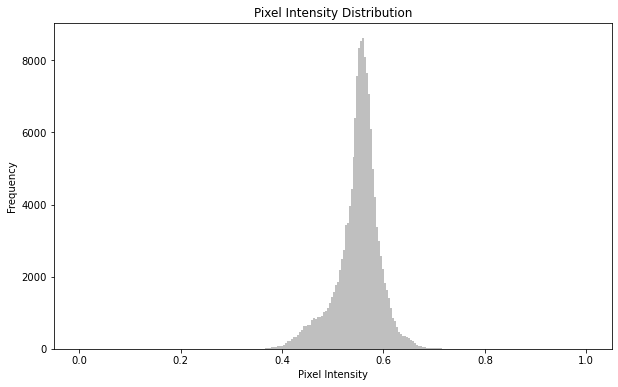

In [15]:
import numpy as np

# Select one image from our batch
sample_image = images[0]  # Taking the first image for example

# Flatten the image to collapse the 3D shape into 1D
flattened_image = sample_image.flatten()

# Plot the histogram of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(flattened_image, bins=256, range=[0,1], color='gray', alpha=0.5)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

The shape of the histogram suggests that most pixels in the image(s) are of medium intensity, with fewer pixels at the extremes (very dark or very light). The peak around the middle (around 0.5) suggests a large concentration of mid-tone values. 

 This suggests that, on average, the images are neither too dark nor too light, which is generally good for training our model later.

## 2.4 Data Visualization
Visualizations can reveal trends and patterns that might not be apparent from raw data. They are essential for communicating findings to stakeholders and for making informed decisions about model development and data preprocessing.

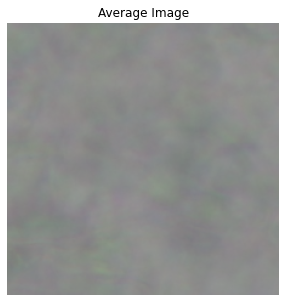

In [16]:
# Calculate the average image
average_image = np.mean(images, axis=0)

# Display the average image
plt.figure(figsize=(5, 5))
plt.imshow(average_image, cmap='gray')
plt.axis('off')
plt.title('Average Image')
plt.show()

# 3 Modeling 


##### Split images from `/data/defungi` folder into train, test and validation sets using  install [split-folders](https://pypi.org/project/split-folders/0.3.1/) library

The dataset comes in a single folder, with subfolders containing images of the classes. We split images in each class into train, validation and test sets.

In [2]:
! pip install split-folders tqdm

In [17]:
#Good old imports
import splitfolders
import os
import pandas as pd

#use  tf version 2.9.0 and up to import from utils
# from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import img_to_array, array_to_img, img_to_array, load_img, ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense



Below, we check the number of items in each folder.

In [18]:
#define path 
path = "data/defungi"

classes = os.listdir(path)
print(len(classes),"Folders Found")

for folder in classes:
  num_items = len(os.listdir(os.path.join(path, folder)))
  print(folder + ":", num_items, " items")


5 Folders Found
H1: 4404  items
H2: 2334  items
H3: 819  items
H5: 818  items
H6: 739  items


The code below does the splitting. Since we only needed this code to run once, it's now commented after the data was split.

In [5]:
# # Split with a ration of items for each set.
# splitfolders.ratio(path, output="data/split-defungi",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Below, we fing the number of items in each class' test, train and validation folders.

In [19]:
#preview the number of items in each split
for i, value in enumerate(classes):
    
    print(f"\nClass {value}: ")
    
    for folder in os.listdir("data/split-defungi"):
       
        print(folder, ":",len(os.listdir(os.path.join("data/split-defungi"+"/"+folder, classes[i]))))
        # values = {split:count for }


Class H1: 
test : 441
train : 3523
val : 440

Class H2: 
test : 234
train : 1867
val : 233

Class H3: 
test : 83
train : 655
val : 81

Class H5: 
test : 83
train : 654
val : 81

Class H6: 
test : 75
train : 591
val : 73


splits appear to have worked well. 

### Loading images using ImageDataGenerator

In [21]:
#preview some images from each class 
train_data_dir = 'data/split-defungi/train/'
val_data_dir  = 'data/split-defungi/val/'
test_data_dir = 'data/split-defungi/test/'

In [134]:
# Get all the data in the directory data/split-defungi/test/ and reshape them
print("\nTest...")

test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(500,500), batch_size=100)

# Get all the data in the directory data/split-defungi/test/, and reshape them
print("\nTrain...")
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir,target_size=(500,500),batch_size=100)

print("\nValidation...")
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir,target_size=(500,500),batch_size=100)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(test_generator)


Test...
Found 916 images belonging to 5 classes.

Train...


Found 7290 images belonging to 5 classes.

Validation...
Found 908 images belonging to 5 classes.


Below, we preview 2 images with their corresponding labels, just to confirm that our data is ready for modelling.

[0. 0. 1. 0. 0.]


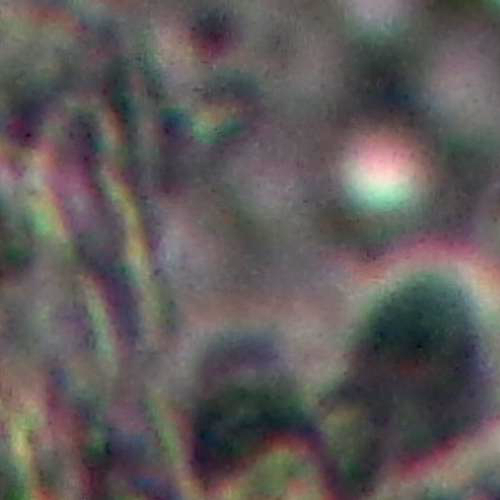

In [135]:
#preview an image or two
print(train_labels[0])
array_to_img((train_images[0]))


[1. 0. 0. 0. 0.]


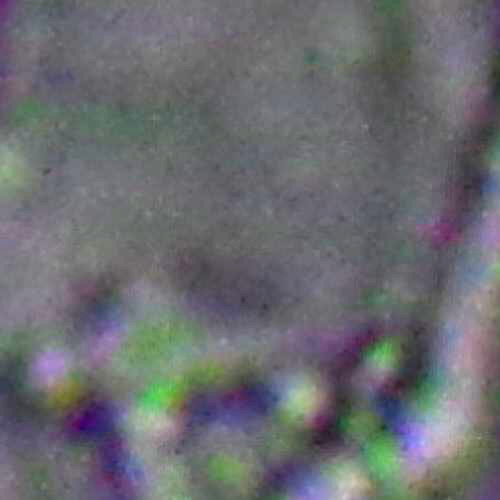

In [136]:
print(val_labels[8])
array_to_img((val_images[8]))

## Baseline Model: Multi-Layer Perceptron 

MLPs take inputs as vectors, and not matrices/tensors. Below, let's check the shape of our data

In [137]:
#check the shape of our input 
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(100, 500, 500, 3)
(100, 500, 500, 3)
(100, 500, 500, 3)


_Interpretation:_
* For the batch we collected, each set contains the specfified number of items.
* Image dimensions are set to 500 x 500, according to the [source paper](https://arxiv.org/abs/2109.07322) 
* Each image is a color image with 3 dimensions (R,G,B)

To convert these tensors to vectors for use with our MLP, we'll flatten the 2nd, 3rd, and 4th dimensions to have a shape of (32, 500x500x3).

Many machine learning algorithms expect input data in the form of a 2D array, where each row represents a single sample and each column represents a feature.


In [138]:
#reshape the images so each will be a 1D vector
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

In [139]:
# See shapes of reshaped inputs

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(100, 750000)
(100, 750000)
(100, 750000)


For faster computation, let's normalize the images by dividing the pixel values by the max possible value (255)

Below, we build our first model. It's a multi-layer perceptron with:
* an input layer 
* one hidden layer
* an output layer with 5 nodes

In [140]:
#Build baseline model 1
model_1  = Sequential()
model_1.add(Dense(100, activation = 'tanh', input_shape=(750000,)))
model_1.add(Dense(32, activation = 'tanh'))
model_1.add(Dense(5, activation = 'softmax'))   

In [141]:
model_1.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['acc']) 

In [142]:
model_1.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 100)               75000100  
_________________________________________________________________
dense_55 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_56 (Dense)             (None, 5)                 165       
Total params: 75,003,497
Trainable params: 75,003,497
Non-trainable params: 0
_________________________________________________________________


In [143]:
results_1 = model_1.fit(train_img, train_labels, epochs = 5, batch_size=64, validation_data = (val_img, val_labels))


Epoch 1/5
2/2 [==============================] - 1s 732ms/step - loss: 1.5989 - acc: 0.3600 - val_loss: 1.3677 - val_acc: 0.4900
Epoch 2/5
2/2 [==============================] - 1s 355ms/step - loss: 1.3001 - acc: 0.5200 - val_loss: 1.2986 - val_acc: 0.4900
Epoch 3/5
2/2 [==============================] - 1s 355ms/step - loss: 1.2476 - acc: 0.5200 - val_loss: 1.2517 - val_acc: 0.4900
Epoch 4/5
2/2 [==============================] - 1s 335ms/step - loss: 1.2263 - acc: 0.5200 - val_loss: 1.2605 - val_acc: 0.4900
Epoch 5/5
2/2 [==============================] - 1s 320ms/step - loss: 1.2389 - acc: 0.5200 - val_loss: 1.2614 - val_acc: 0.4900


We create a function `visualize_training_results` below that we'll use to visualize training results for each of our models. 

In [149]:
#a function we'll be using to visualize results
def visualize_training_results(results, epochs, model_name):
    plt.figure(figsize=(10,6))
    plt.plot (range(1,epochs), results.history['loss'], label = "Train Loss")
    plt.plot (range(1,epochs), results.history['val_loss'], label = "Validation Loss")
    plt.title(model_name+"Loss plot")
    plt.xlabel ("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot (range(1,epochs), results.history['accuracy'], label = "Train Accuracy")
    plt.plot (range(1,epochs), results.history['val_accuracy'], label = "Validation Accuracy")
    plt.title(model_name+"Accuracy  plot")
    plt.xlabel ("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()     

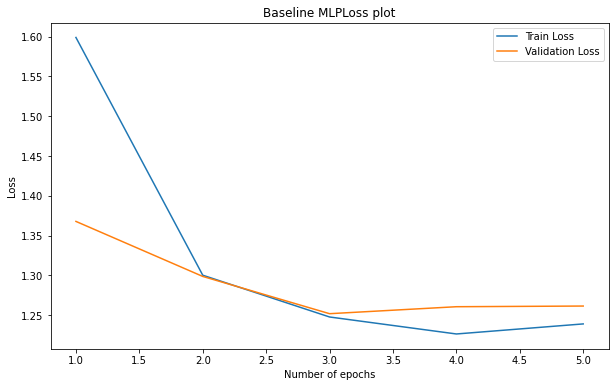

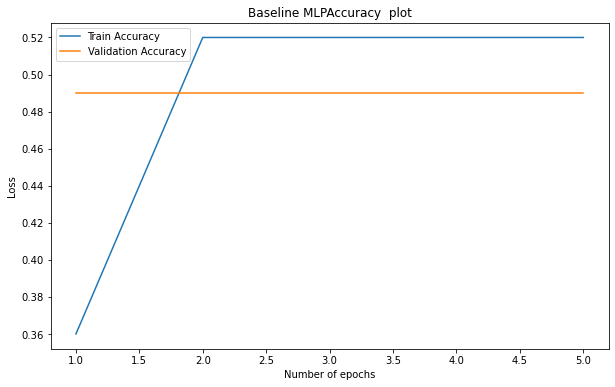

In [148]:
visualize_training_results(results_1, 6, "Baseline MLP ")

## Model II - Convolutional Neural Network

A convolutional neural network (CNN) is a type of deep learning network architecture. Convolutional neural networks offer superior performance with image, speech and audio signal inputs. 

The layers of a CNN increase compexity with depth, with earlier layers focusing on simple features such as colors and edges.
As an image goes through the network, deeper layers recognize larger elements or shapes until the intended object is identified. 

Our model below includes 
* `Conv2D` layers = slides over the input data, performing an elementwise multiplication for every location it slides over. It transforms a 2D matrix of features into a different 2D matrix of features.
* `MaxPooling2D` layer - This downsamples it's input along the dimensions passed in as a tuple. Here we use (2,2) for 2D 
* `Flatten` layer - Converts the 2D matrix data to a vector before passing it on to the Dense layers.
* `Dense` layer - We use one of these to  introduce additional capacity for learning high-level abstractions. 
* `Output Layer` - Our output layer is a dense layer with 5 nodes, corresponding to our 5 target classification classes. We use a softmax activation function which fits this use case. 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:

# Define data paths
train_path = "data/split-defungi/train"
val_path = "data/split-defungi/val"
test_path = "data/split-defungi/test"

# Define image dimensions and batch size
img_width, img_height = 500, 500
batch_size = 32

# Create data generators with augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_path,
                                                target_size=(img_width, img_height),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = val_datagen.flow_from_directory(test_path,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # Assuming there are 5 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)




Found 7290 images belonging to 5 classes.
Found 908 images belonging to 5 classes.
Found 916 images belonging to 5 classes.
Epoch 1/10
227/227 [==============================] - 2315s 10s/step - loss: 1.4392 - accuracy: 0.5564 - val_loss: 1.0116 - val_accuracy: 0.5960
Epoch 2/10
227/227 [==============================] - 4948s 22s/step - loss: 1.0113 - accuracy: 0.5985 - val_loss: 0.9447 - val_accuracy: 0.6138
Epoch 3/10
227/227 [==============================] - 1538s 7s/step - loss: 0.9338 - accuracy: 0.6305 - val_loss: 0.9195 - val_accuracy: 0.6540
Epoch 4/10
227/227 [==============================] - 1796s 8s/step - loss: 0.9377 - accuracy: 0.6232 - val_loss: 0.9286 - val_accuracy: 0.6384
Epoch 5/10
227/227 [==============================] - 1548s 7s/step - loss: 0.9386 - accuracy: 0.6283 - val_loss: 0.9423 - val_accuracy: 0.6194
Epoch 6/10
139/227 [=================>............] - ETA: 9:31 - loss: 0.9121 - accuracy: 0.6538

KeyboardInterrupt: 

### Model II Results and interpretation 

The model above took close to 3 hours to run 5 epochs. We could not afford any more time so we terminated it. Using the information we had obtained so far, we evaluate the model on the test set. 

By the point we were terminating the convolutional neural network above, the best accuracy we've hit is `65%` on the train set and `61%` on the validation set. 


In [73]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc}")

28/28 [==============================] - 50s 2s/step - loss: 0.9436 - accuracy: 0.6250
Test Accuracy: 0.625


Test Accuracy for our CNN model is `62.5%` which isn't that badly off. 

Next, we'll use [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2), a pe-trained network to try and improve performance

## Model III - Transfer Learning with MobileNetV2 model 

Transfer learning is the method of starting with a pre-trained model and training it for a new -- related -- problem domain. The pre-trained network serves as transferred knowledge to be applied in another domain

[MobileNet-v2](https://arxiv.org/abs/1801.04381v4) is a convolutional neural network that is 53 layers deep. Since it's intended to run on mobile devices, we hoped it would be kinder to the computation resources and time at our disposal. 

MobileNetV2 is known for efficiency and will be used as a feature extractor. \
We'll then add a few dense layers on top, freeze the weights of the pre-trained layers and only train the newly added dense layers.

In [77]:
from tensorflow.keras.applications import MobileNetV2


In [79]:
# Create MobileNetV2 base model with pre-trained weights
base_model = MobileNetV2(input_shape=(img_width, img_height, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the weights of the pre-trained layers
# Freezing the convolutional base before compiling and training the model 
# prevents the weigths in the base_model layer from being updated during training

for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming there are 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc}")

Epoch 1/10
227/227 [==============================] - 977s 4s/step - loss: 0.9431 - accuracy: 0.6161 - val_loss: 0.8108 - val_accuracy: 0.6629
Epoch 2/10
227/227 [==============================] - 905s 4s/step - loss: 0.7953 - accuracy: 0.6746 - val_loss: 0.8016 - val_accuracy: 0.6763
Epoch 3/10
227/227 [==============================] - 904s 4s/step - loss: 0.7298 - accuracy: 0.7071 - val_loss: 0.7385 - val_accuracy: 0.7154
Epoch 4/10
227/227 [==============================] - 903s 4s/step - loss: 0.6901 - accuracy: 0.7229 - val_loss: 0.7148 - val_accuracy: 0.7176
Epoch 5/10
227/227 [==============================] - 903s 4s/step - loss: 0.6695 - accuracy: 0.7323 - val_loss: 0.7303 - val_accuracy: 0.7154
Epoch 6/10
227/227 [==============================] - 903s 4s/step - loss: 0.6598 - accuracy: 0.7357 - val_loss: 0.7138 - val_accuracy: 0.7321
Epoch 7/10
227/227 [==============================] - 904s 4s/step - loss: 0.6347 - accuracy: 0.7406 - val_loss: 0.6921 - val_accuracy: 0.7321

### Model III Results and interpretation 

Test Accuracy for put second model improved significantly, hitting highs of `75%` on the train set, `74%` on the validation set and `71%` on the test set.

Let's visualize the results:

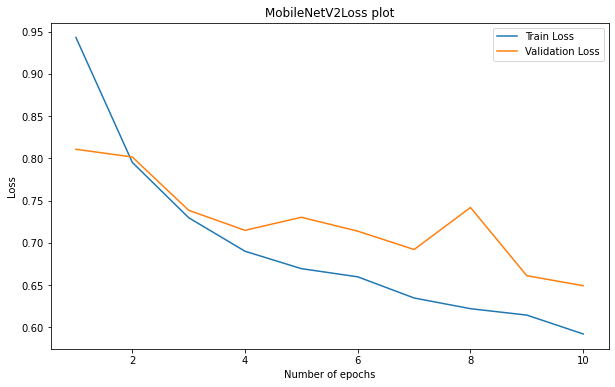

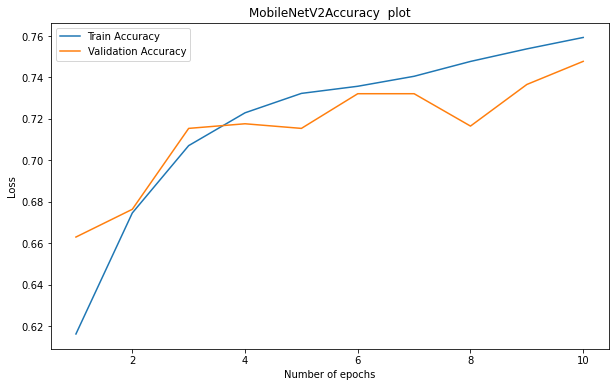

In [108]:

visualize_training_results(history, 11, 'MobileNetV2')

The model appears to be a significant improvement over our baseline MLP and the CNN. It's not overfitting and the accuracy seems to improve with the number of epochs. 

However, time is still an issue and the accuracy could still be better. Let's see if we can get the accuracy even higher.

## Model IV: EfficientNetB0


One of the main challenges we're facing is the extremely long time it's taking to fit and eveluate these models, with our best now taking over 2 hours. Our next model, EfficientNetB0, attempts to help us with that.








In [115]:
from tensorflow.keras.applications import EfficientNetB0


In [116]:
# Create EfficientNetB0 base model with pre-trained weights


base_model = EfficientNetB0(
    input_shape=(img_width, img_height, 3),
                             include_top=False,
                             weights='imagenet'
)


# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming there are 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_eff = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)


16711680/16705208 [==============================] - 3s 0us/step
Epoch 1/10
227/227 [==============================] - 2154s 9s/step - loss: 1.3541 - accuracy: 0.4820 - val_loss: 1.3409 - val_accuracy: 0.4866
Epoch 2/10
227/227 [==============================] - 1459s 6s/step - loss: 1.3455 - accuracy: 0.4833 - val_loss: 1.3492 - val_accuracy: 0.4821
Epoch 3/10
 25/227 [==>...........................] - ETA: 18:16 - loss: 1.3439 - accuracy: 0.4762

KeyboardInterrupt: 

### Model IV Results and interpretation 

1 hour and  2 epochs later, our model was showing signs of performing worse than MobileNetV2. We terminated the training to save time and try other models.

## Mdel V: ResNet101

Resnets help us deal with the issue of `vanishing gradients`. When the network is too deep, the gradients from where the loss function is calculated easily shrink to zero after several applications of the chain rule. 

This results to the weights never updating their values and therefore, no learning is being performed.


In [117]:
from tensorflow.keras.applications import ResNet101


In [118]:
# Create ResNet101 base model with pre-trained weights
base_model = ResNet101(input_shape=(img_width, img_height, 3),
                       include_top=False,
                       weights='imagenet')

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming there are 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=val_generator.samples // batch_size)



171450368/171446536 [==============================] - 23s 0us/step
Epoch 1/10
227/227 [==============================] - ETA: 0s - loss: 1.4099 - accuracy: 0.4532 

KeyboardInterrupt: 

### Model V Results and interpretation 
We interrupt the training after the model takes 1hr 28 minutes to go through just one epoch The accuracy obtained so far is about 45% for the train set and 49% for the test set. 

Let's test its performance on the test set anyway:

In [119]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc}")

28/28 [==============================] - 522s 19s/step - loss: 1.2999 - accuracy: 0.4911
Test Accuracy: 0.4910714328289032


## Model Evaluation and Conclusion

Despite the many challenges with time, we managed to evaluate the performance of our models.

Our model Results were as below:

| Model           | Train Accuracy | Validation Accuracy | Test Accuracy |
|-----------------|----------------|----------------------|---------------|
| MobileNetV2     | 76%            | 75%                  | 71%           |
| CNN             | 65%            | 62%                  | 62.5%         |
| ResNet101       | 45%            | 44%                  | 49%           |
| MLP             | 52%            | 49%                  | 48%           |
| EfficientNetB0  | 48%            | 48%                  | 45%           |


`MobileNetV2` emerged as the model with the highest accuracy, and is the one to choose for further fine tuning and deployment. 